In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_swiss_roll
# mnist 
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from lamp import Pinv_ilamp
from NNinv import NNinv_torch
from rbf_inv import RBFinv
from multilateration import MDSinv
from gradient_map import get_gradient_map

### Generate some data

In [4]:
# X, y = make_swiss_roll(n_samples=2000, noise=0.2, random_state=0, hole=False)

# ## scale the data to [0,1] is required for the NNinv
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

# ## plot the original data
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap=plt.cm.jet)

## MNIST
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.astype('float32')/255.0
y = y.astype('int64')


X, _, y, _ = train_test_split(X, y, train_size=10000, random_state=420) ## you may need to use all the data 

## select only 0 and 7 || or try 1 and 7
mask = (y == 0) | (y == 7)
X = np.array(X[mask])
y = np.array(y[mask])
print(X.shape, y.shape)


C:\Users\yuwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(2051, 784) (2051,)


### Build  $P$ and $P^{-1}$

C:\Users\yuwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


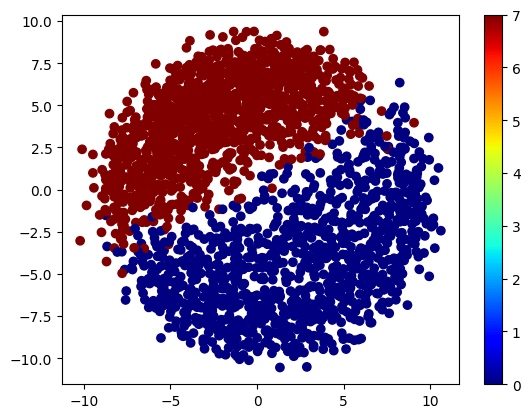

In [5]:
## P, using MDS
X2d = MDS(n_components=2, random_state=42, n_jobs=-1).fit_transform(X)

plt.scatter(X2d[:,0], X2d[:,1], c=y, cmap=plt.cm.jet)
# cbar
plt.colorbar()

In [6]:
## Pinv with ilamp
ilamp = Pinv_ilamp(k=6)
ilamp.fit(X2d, X)

## Pinv with NNinv
nninv = NNinv_torch(dims=[2048, 2048, 2048, 2048],) ## this structure is according the original paper, but it seems too large for most of the datasets we teset (like any 3D dataset, or the MNIST). But it works
nninv.fit(X2d, X, epochs=100)

## Pinv with RBF
rbf = RBFinv()
rbf.fit(X2d, X)

## MDSinv
mdsinv = MDSinv()
mdsinv.fit(X2d, X)

device:  cuda:0
Epoch 1/100, Loss: 0.09724942
Epoch 2/100, Loss: 0.06613791
Epoch 3/100, Loss: 0.05468888
Epoch 4/100, Loss: 0.05219123
Epoch 5/100, Loss: 0.04831213
Epoch 6/100, Loss: 0.04542216
Epoch 7/100, Loss: 0.04397951
Epoch 8/100, Loss: 0.04250947
Epoch 9/100, Loss: 0.04190315
Epoch 10/100, Loss: 0.04163583
Epoch 11/100, Loss: 0.04204204
Epoch 12/100, Loss: 0.04173967
Epoch 13/100, Loss: 0.04146368
Epoch 14/100, Loss: 0.04121516
Epoch 15/100, Loss: 0.04054887
Epoch 16/100, Loss: 0.04088778
Epoch 17/100, Loss: 0.04107999
Epoch 18/100, Loss: 0.04102540
Epoch 19/100, Loss: 0.04065704
Epoch 20/100, Loss: 0.04092837
Epoch 21/100, Loss: 0.04130652
Epoch 22/100, Loss: 0.04254247
Epoch 23/100, Loss: 0.04022082
Epoch 24/100, Loss: 0.04126114
Epoch 25/100, Loss: 0.03997424
Epoch 26/100, Loss: 0.04122961
Epoch 27/100, Loss: 0.04067774
Epoch 28/100, Loss: 0.04050353
Epoch 29/100, Loss: 0.03988360
Epoch 30/100, Loss: 0.04039246
Epoch 31/100, Loss: 0.03991356
Epoch 32/100, Loss: 0.04018102
E

### Inverse proejction some 2D points

In [36]:
## sample some points in the 2D space

xmin, xmax = X2d[:,0].min(), X2d[:,0].max()
ymin, ymax = X2d[:,1].min(), X2d[:,1].max()

x_ = np.linspace(xmin, xmax, 10)
y_ = np.linspace(ymin, ymax, 10)

xx, yy = np.meshgrid(x_, y_)
samples = np.c_[xx.ravel(), yy.ravel()]

## Pinv with ilamp
samples_ilamp = ilamp.transform(samples)

## Pinv with NNinv
samples_nninv = nninv.transform(samples)

## Pinv with RBF
samples_rbf = rbf.transform(samples)

## MDSinv
samples_mdsinv = mdsinv.transform(samples)

100%|██████████| 100/100 [00:00<00:00, 99627.17it/s]


KeyboardInterrupt: 

In [8]:
# mdsinv_closet = MDSinv(point_selection='closest')
# mdsinv_closet.fit(X2d, X)
# ## MDSinv
# samples_mdsinv_close = mdsinv.transform(samples)

Text(0.5, 0.98, 'RBF')

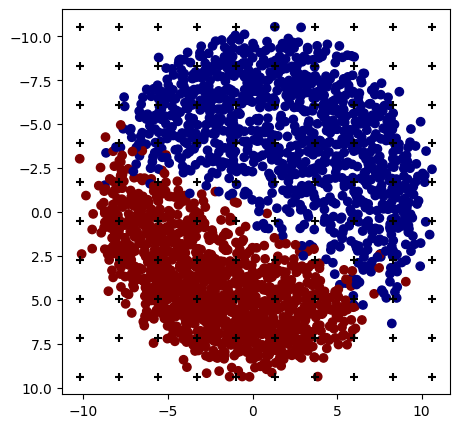

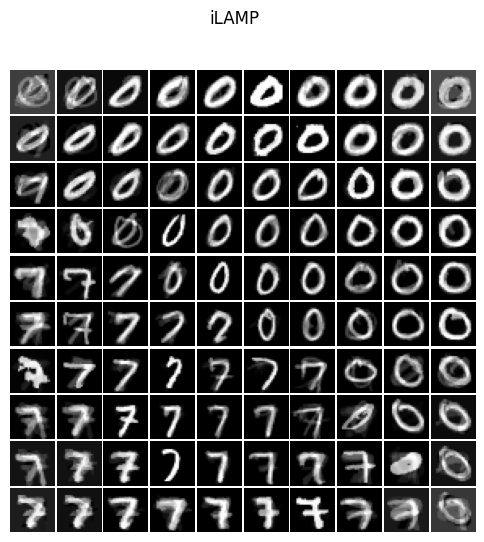

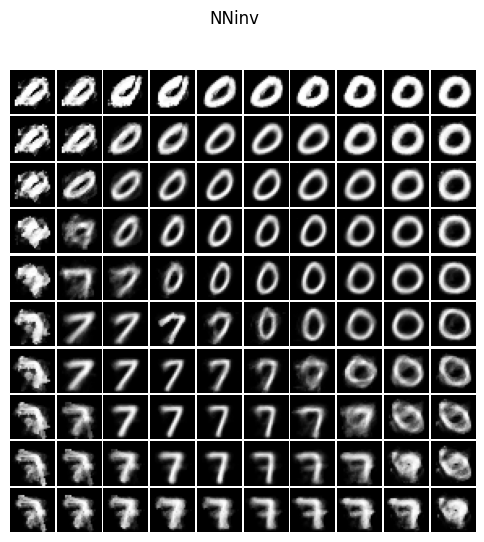

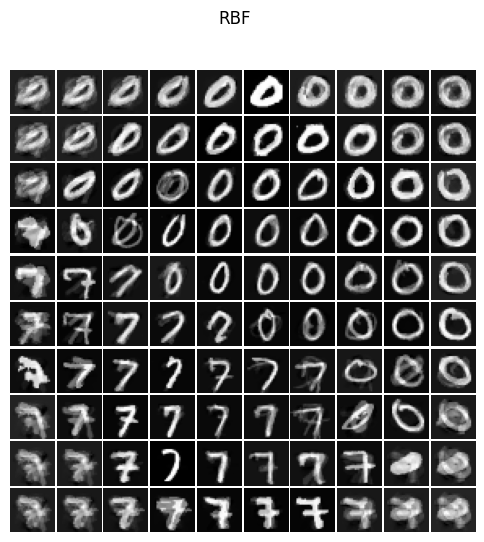

In [9]:
## plot the results
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(X2d[:,0], X2d[:,1], c=y, cmap=plt.cm.jet)
ax.scatter(samples[:,0], samples[:,1], c='black', marker='+')
ax.invert_yaxis()

## results of ilamp
fig1, axes = plt.subplots(10, 10, figsize=(6,6))
fig1.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_ilamp[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig1.suptitle('iLAMP')

## results of NNinv
fig2, axes = plt.subplots(10, 10, figsize=(6,6))
fig2.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_nninv[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig2.suptitle('NNinv', )

## results of RBF
fig3, axes = plt.subplots(10, 10, figsize=(6,6))
fig3.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_rbf[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig3.suptitle('RBF')

# ## results of MDSinv
# fig4, axes = plt.subplots(10, 10, figsize=(6,6))
# fig4.subplots_adjust(hspace=0.05, wspace=0.05)
# for i in range(100):
#     ax = axes[i//10, i%10]
#     ax.imshow(samples_mdsinv[i].reshape(28,28), cmap='gray')
#     ax.axis('off')
# fig4.suptitle('MDSinv')

# ## results of MDSinv
# fig5, axes = plt.subplots(10, 10, figsize=(6,6))
# fig5.subplots_adjust(hspace=0.05, wspace=0.05)
# for i in range(100):
#     ax = axes[i//10, i%10]
#     ax.imshow(samples_mdsinv_close[i].reshape(28,28), cmap='gray')
#     ax.axis('off')

# fig5.suptitle('MDSinv_closest')

### compute gradient maps

In [64]:
inv_methods = {
    'iLAMP': ilamp,
    'NNInv': nninv,
    'RBF': rbf,
    # 'MDSinv': mdsinv,
    # 'mdsinv_closest': mdsinv_closet
}

map_grid = 100

grad_map_dict = {}
nD_grids_dict = {}
global_min = 1e10
global_max = -1e10
for name, inv in inv_methods.items():
    grad_map, nD_grid = get_gradient_map(inv, X2d, map_grid)
    grad_map_dict[name] = grad_map.reshape(map_grid, map_grid)
    print(min(grad_map), max(grad_map))
    global_min = min(global_min, min(grad_map))
    global_max = max(global_max, max(grad_map))
    nD_grids_dict[name] = nD_grid

100%|██████████| 10404/10404 [00:00<00:00, 139076.70it/s]


1.3032967426294053 29.342997994897985
0.7044679 9.102686
1.5913300855865973 30.05880537840512


0.020400012443583374 0.975614936502845
0.0 0.28609803
0.030212304855120012 1.0


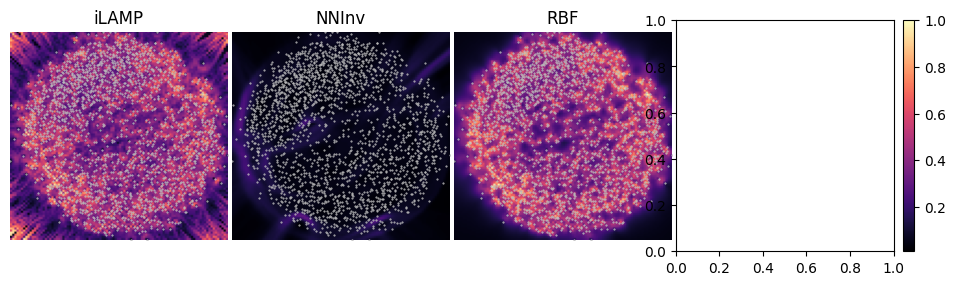

In [71]:

fig, axes = plt.subplots(1, 4, figsize=(12,3))

# white space
fig.subplots_adjust(wspace=0.02)

for i, (name, grad_map) in enumerate(grad_map_dict.items()):
    ax = axes[i]
    scaled_grad_map = (grad_map - global_min) / (global_max - global_min)
    print(scaled_grad_map.min(), scaled_grad_map.max())

    # flipp the x axis
    scaled_grad_map = np.flip(scaled_grad_map, axis=0)

    ### scaled individually
    # im = ax.imshow(scaled_grad_map, cmap='magma') ## this will rescale the data to [0,1]
    
    ## scaled globally
    image = cm.magma(scaled_grad_map)
    im = ax.imshow(image, cmap='magma', extent=[xmin, xmax, ymin, ymax])
    ax.set_title(name)
    ax.axis('off')
    ax.scatter(X2d[:,0], X2d[:,1], c='#BBBBBB', s=1, marker='.')

fig.colorbar(im,  ax=axes, orientation='vertical', fraction=0.04, pad=0.01, )


0.020400012443583374 0.975614936502845
0.0 0.28609803
0.030212304855120012 1.0


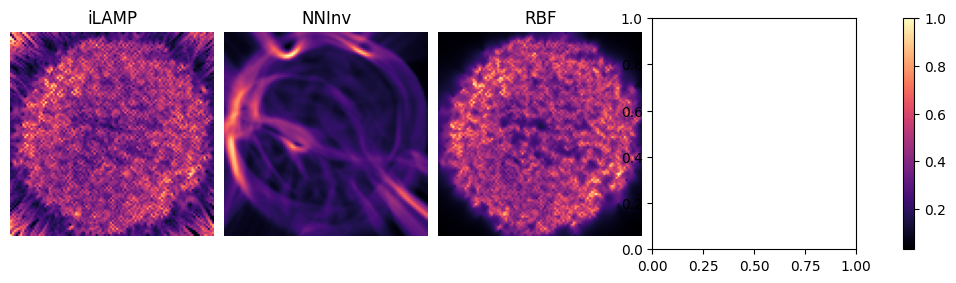

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))

# white space
fig.subplots_adjust(wspace=0.05)

for i, (name, grad_map) in enumerate(grad_map_dict.items()):
    ax = axes[i]
    scaled_grad_map = (grad_map - global_min) / (global_max - global_min)
    print(scaled_grad_map.min(), scaled_grad_map.max())

    ### scaled individually
    im = ax.imshow(scaled_grad_map, cmap='magma') ## this will rescale the data to [0,1]

    ## scaled globally
    # image = cm.magma(scaled_grad_map)
    # im = ax.imshow(image, cmap='magma')
    ax.set_title(name)
    ax.axis('off')



fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.04, )